In [4]:
import numpy as np
from scipy.stats import norm

print("What is the price of the stock?")
stock = int(input())
print("What is the strike price?")
strike = int(input())
print("what is the volatility(standard deviation)? Enter whole number")
sd = float(input())/100
print("What is the interest rate? Enter whole number")
ir = float(input())/100
print("What is the duration of the contract?(in years)")
years = int(input())


def black_scholes_call(S, X, sigma, r, t):
    d1 = (np.log(S/X) + (r + ((sigma**2)/2))*t) / (sigma * np.sqrt(t))
    d2 = d1 - (sigma * np.sqrt(t))
    C = (S * norm.cdf(d1)) - (X * np.exp(-r*t) * norm.cdf(d2))
    return C
black_scholes_call(stock, strike, sd, ir, years)


What is the price of the stock?


 100


What is the strike price?


 100


what is the volatility(standard deviation)? Enter whole number


 30


What is the interest rate? Enter whole number


 5


What is the duration of the contract?(in years)


 1


np.float64(14.231254785985819)

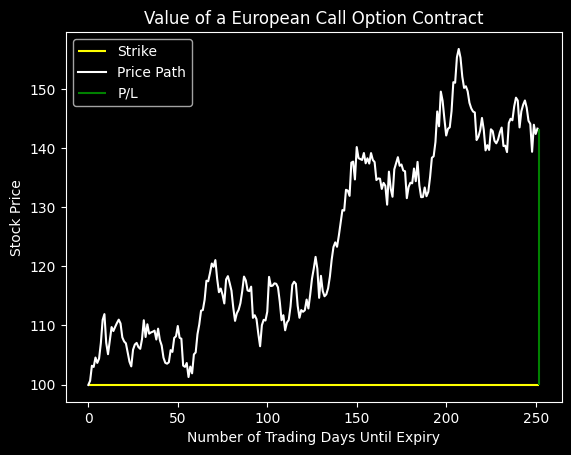

Premium at t=0: 14.231254785985819
P/L: 29.066924834018458


In [5]:
import matplotlib.pyplot as plt
import qfin as qf

mu = ir
dt = years/(252 * years)

path = qf.simulations.GeometricBrownianMotion(stock, mu, sd, dt, years)

plt.title("Value of a European Call Option Contract")
plt.hlines(strike, 0, years * 252, label='Strike', color='yellow')
plt.plot(path.simulated_path, label='Price Path', color='white')
if max(path.simulated_path[-1] - strike, 0) == 0:
    plt.vlines(years * 252, path.simulated_path[-1], strike, color='red', label="P/L")
else:
    plt.vlines(years * 252, strike, path.simulated_path[-1], color='green', label="P/L")
plt.style.use('dark_background')
plt.xlabel('Number of Trading Days Until Expiry')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

print("Premium at t=0:", black_scholes_call(stock, strike, sd, ir, years))
print("P/L:", max(path.simulated_path[-1] - strike, 0) - black_scholes_call(stock, strike, sd, ir, years))

In [6]:
print("Call Price:", black_scholes_call(stock, strike, sd, ir, years))
print("What is the Market Price of a Call Option Contract?")
marketprice = float(input())
print("Price discrepancy:", black_scholes_call(stock, strike, sd, ir, years) - marketprice)


Call Price: 14.231254785985819
What is the Market Price of a Call Option Contract?


 14.1


Price discrepancy: 0.13125478598581886


How many shares do you want to trade?


 100


How many times do you want to repeat this trade?


 100


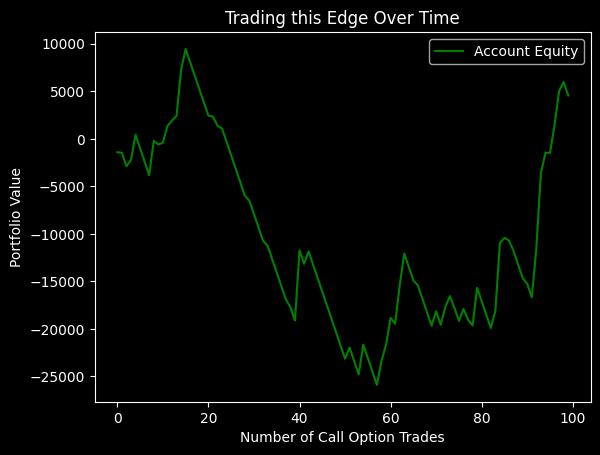

The value of the option per trade is $ 45.6
The total value of the call option is $ 4560.37


In [7]:
print("How many shares do you want to trade?")
shares = int(input())
print("How many times do you want to repeat this trade?")
rep = int(input())

premiums = marketprice * shares
pnl = []

for i in range(rep):
    path = qf.simulations.GeometricBrownianMotion(stock, mu, sd, dt, years)
    pnl.append(max(path.simulated_path[-1] - strike, 0) * shares - premiums)
    
plt.title("Trading this Edge Over Time")
if np.sum(pnl) <= 0:
    plt.plot(np.cumsum(pnl), label="Account Equity", color="red")
else:
    plt.plot(np.cumsum(pnl), label="Account Equity", color="green")
plt.style.use('dark_background')
plt.ylabel("Portfolio Value")
plt.xlabel("Number of Call Option Trades")
plt.legend()
plt.show()

mean = np.mean(pnl)
total = np.sum(pnl)
print("The value of the option per trade is $",round(mean, 2))
print("The total value of the call option is $",round(total, 2))

In [8]:
volatilities = np.linspace(start = sd - .1, stop = sd + .1, num = 10)
option_prices = np.linspace(start = marketprice - 2.5, stop = marketprice + 2.5, num = 10)

call_matrix = np.zeros((len(option_prices), len(volatilities)))

for i in range(rep):
    for v, vol in enumerate(volatilities):
        for o, premium in enumerate(option_prices):
            new_path = qf.simulations.GeometricBrownianMotion(stock, mu, vol, dt, years)
            newprofit = round(max(new_path.simulated_path[-1] - strike, 0) - premium, 2) 
            call_matrix[v,o] += newprofit
        
print(call_matrix)

[[-139.78 -140.17 -240.41 -526.43 -282.19 -431.04 -184.39 -510.73 -483.46
  -536.44]
 [-151.78  -80.02 -133.6   104.33 -479.79  -59.   -497.1  -270.5  -330.48
  -191.24]
 [ -17.37  259.33 -146.05 -148.49 -267.92 -264.62 -486.92 -167.74 -545.16
  -510.46]
 [ -26.75  264.45 -105.02  399.47 -257.27 -266.33   74.08  192.98  137.31
   -59.41]
 [ 308.81  290.53  149.1   -40.39 -130.66 -109.9  -293.94  195.94 -328.22
  -468.51]
 [ 834.97  396.02  278.24  458.17  343.32 -236.42   56.54   36.04   47.39
    88.1 ]
 [ 265.64  243.92  226.71  148.72   14.67  369.14  220.5  -160.21  302.72
  -224.47]
 [ 235.5   303.28  827.    434.04  766.6   430.21  142.78 -160.95  -51.63
   -61.1 ]
 [ 378.77  358.15  350.76  749.12 -268.85  167.64  449.67  345.02  175.07
    36.24]
 [ 713.88  750.89  756.76  249.38  650.64   23.34  288.01  649.11  191.15
   123.67]]


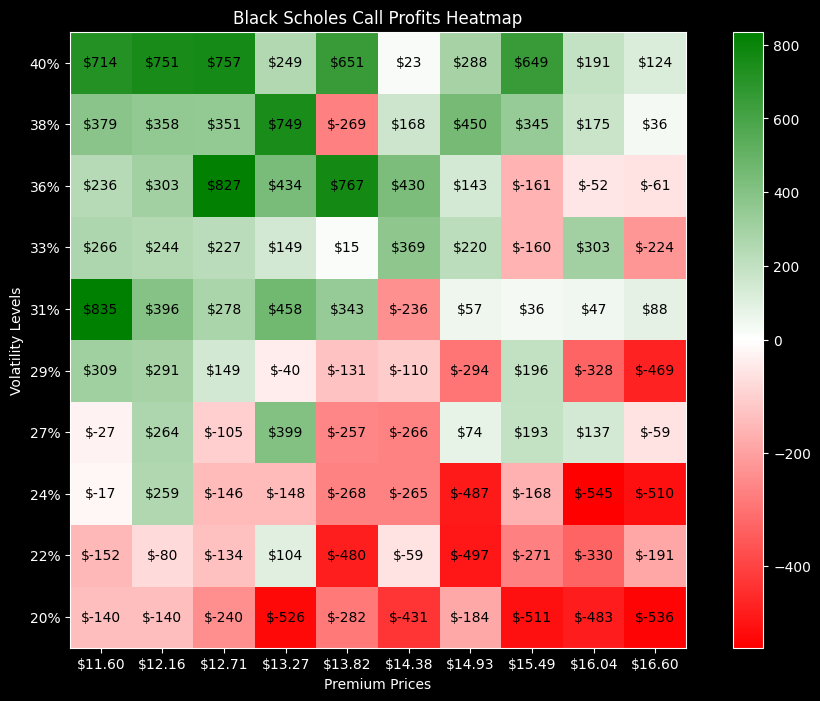

In [9]:
from matplotlib.colors import LinearSegmentedColormap as lsc
from matplotlib.colors import TwoSlopeNorm as tsn

colors = ["red", "white", "green"]
cmap = lsc.from_list("loss_win", colors)

vmin = call_matrix.min()
vmax = call_matrix.max()
norm = tsn(vcenter = 0, vmin = call_matrix.min(), vmax = call_matrix.max())

fig, ax = plt.subplots(figsize = (12, 8))
cax = ax.matshow(call_matrix, cmap=cmap, norm=norm)
fig.colorbar(cax)

for v in range(len(volatilities)):
    for o in range(len(option_prices)):
        text = ax.text(o, v, f"${round(call_matrix[v, o])}",
                    ha="center", va="center", color="black")

ax.set_xticks(range(len(option_prices)))
ax.set_yticks(range(len(volatilities)))

ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(np.arange(len(option_prices)))
ax.set_xticklabels([f"${option:.2f}" for option in option_prices])

ax.set_yticks(np.arange(len(volatilities)))
ax.set_yticklabels([f"{vol*100:.0f}%" for vol in volatilities])

ax.invert_yaxis()

ax.set_xlabel('Premium Prices')
ax.set_ylabel('Volatility Levels')
ax.set_title('Black Scholes Call Profits Heatmap')

plt.show()


